## Setup

install

In [ ]:
!pip install -q sentence_transformers

imports

In [ ]:
from sentence_transformers import SentenceTransformer
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pprint import pprint
from utils import parse_data, predict_similarity_cosine, predict_similarity_dot, get_measure, get_maximum_point, get_classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


settings

In [ ]:
DATASET_FOLDER_PATH = 'drive/MyDrive/Colab Notebooks/nn/dataset/WikiQACorpus/WikiQACorpus'
MODEL_FOLDER_PATH = 'drive/MyDrive/Colab Notebooks/nn/models'
MODEL_FOLDER_NAME = '2022_05_16_18_02_28'

## Prepare

load dataset

In [ ]:
train_dataset_path = os.path.join(DATASET_FOLDER_PATH, 'WikiQA-train.tsv') # drive path
dev_dataset_path = os.path.join(DATASET_FOLDER_PATH, 'WikiQA-dev.tsv')
#train_dataset_path = 'C:\\some_folder' # local path

In [ ]:
df_train = pd.read_csv(train_dataset_path, delimiter='\t')
df_dev = pd.read_csv(dev_dataset_path, delimiter='\t')

In [ ]:
df_train.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


In [ ]:
questions_train, answers_train, labels_train = parse_data(df_train)
questions_dev, answers_dev, labels_dev = parse_data(df_dev)

load model

In [ ]:
model_save_path = os.path.join(MODEL_FOLDER_PATH, MODEL_FOLDER_NAME)
#model_cosine = SentenceTransformer(model_save_path)
model_cosine = SentenceTransformer(os.path.join(MODEL_FOLDER_PATH, '2022_06_08_18_23_46'))
model_not_trained = SentenceTransformer(os.path.join(MODEL_FOLDER_PATH, '2022_06_08_20_11_06'))
#model_not_trained = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

encode

In [ ]:
'''
predicted_similarity_not_trained = predict_similarity_cosine(model_not_trained, questions_dev, answers_dev)
predicted_similarity_cosine = predict_similarity_cosine(model_cosine, questions_dev, answers_dev)
predicted_similarity_dot = predict_similarity_dot(model_cosine, questions_dev, answers_dev)
'''
#'''
predicted_similarity_not_trained = predict_similarity_dot(model_not_trained, questions_dev, answers_dev)
predicted_similarity_cosine = predict_similarity_dot(model_cosine, questions_dev, answers_dev)
predicted_similarity_dot = predict_similarity_dot(model_cosine, questions_dev, answers_dev)
#'''

In [ ]:
'''
predicted_similarity_not_trained = predict_similarity_cosine(model_not_trained, questions_train, answers_train)
predicted_similarity_cosine = predict_similarity_cosine(model_cosine, questions_train, answers_train)
predicted_similarity_dot = predict_similarity_dot(model_cosine, questions_train, answers_train)
labels_dev = labels_train
'''

'\npredicted_similarity_not_trained = predict_similarity_cosine(model_not_trained, questions_train, answers_train)\npredicted_similarity_cosine = predict_similarity_cosine(model_cosine, questions_train, answers_train)\npredicted_similarity_dot = predict_similarity_dot(model_cosine, questions_train, answers_train)\nlabels_dev = labels_train\n'

## Visualize

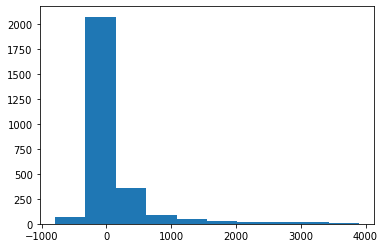

In [ ]:
plt.hist([round(p*100) for p in predicted_similarity_not_trained])
plt.show()

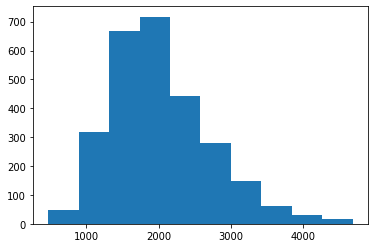

In [ ]:
plt.hist([round(p*100) for p in predicted_similarity_cosine])
plt.show()

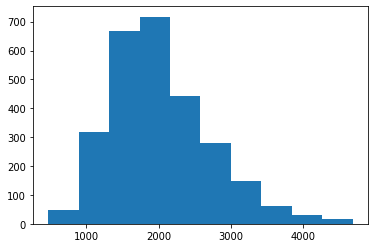

In [ ]:
plt.hist([round(p*100) for p in predicted_similarity_dot])
plt.show()

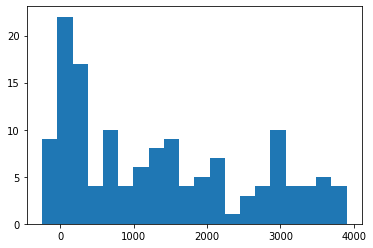

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_not_trained, labels_dev) if l == 1.0], bins=20)
plt.show()

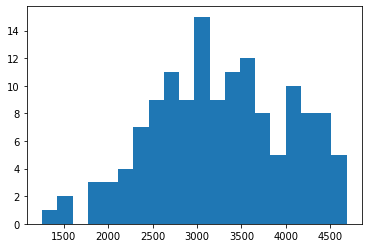

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_cosine, labels_dev) if l == 1.0], bins=20)
plt.show()

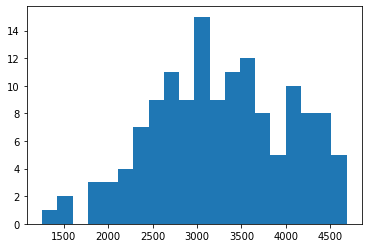

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_dot, labels_dev) if l == 1.0], bins=20)
plt.show()

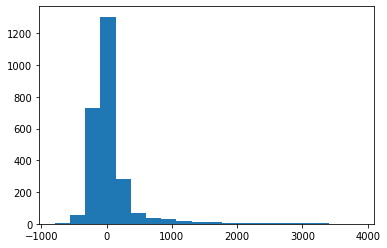

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_not_trained, labels_dev) if l == 0.0], bins=20)
plt.show()

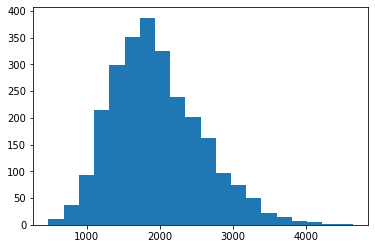

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_cosine, labels_dev) if l == 0.0], bins=20)
plt.show()

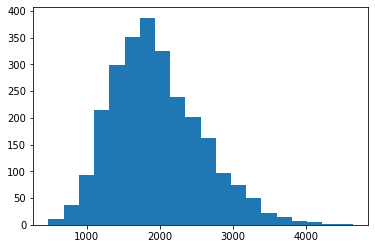

In [ ]:
plt.hist([round(p*100) for p, l in zip(predicted_similarity_dot, labels_dev) if l == 0.0], bins=20)
plt.show()

## Analyze

In [ ]:
classification_reports_not_trained = []
classification_reports_cosine = []
classification_reports_dot = []

thresholds = [l for l in list(range(1, 100, 1))]
for threshold in thresholds:
    classification_reports_not_trained.append(get_classification_report(labels_dev, threshold, predicted_similarity_not_trained))
    classification_reports_cosine.append(get_classification_report(labels_dev, threshold, predicted_similarity_cosine))
    classification_reports_dot.append(get_classification_report(labels_dev, threshold, predicted_similarity_dot))

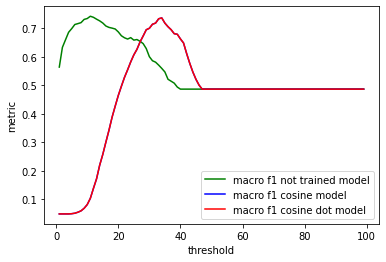

In [ ]:
plt.plot(thresholds, get_measure(classification_reports_not_trained, 'macro avg', 'f1-score'), 'g', label='macro f1 not trained model')
plt.plot(thresholds, get_measure(classification_reports_cosine, 'macro avg', 'f1-score'), 'b', label='macro f1 cosine model')
plt.plot(thresholds, get_measure(classification_reports_dot, 'macro avg', 'f1-score'), 'r', label='macro f1 cosine dot model')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.legend(loc="lower right")
#annot_max(thresholds, [c['1']['recall'] for c in c1_list2])
plt.show()

In [ ]:
xmax_not_trained, ymax = get_maximum_point(thresholds, classification_reports_not_trained, 'macro avg', 'f1-score')
print(f'NOT TRAINED >>> best threshold = {xmax_not_trained}, best measure = {ymax}')
xmax_cosine, ymax = get_maximum_point(thresholds, classification_reports_cosine, 'macro avg', 'f1-score')
print(f'COSINE      >>> best threshold = {xmax_cosine}, best measure = {ymax}')
xmax_dot, ymax = get_maximum_point(thresholds, classification_reports_dot, 'macro avg', 'f1-score')
print(f'COSINE DOT  >>> best threshold = {xmax_dot}, best measure = {ymax}')

NOT TRAINED >>> best threshold = 11, best measure = 0.7427259521124758
COSINE      >>> best threshold = 34, best measure = 0.7368307719603393
COSINE DOT  >>> best threshold = 34, best measure = 0.7368307719603393


In [ ]:
pprint(classification_report(labels_dev, [1.0 if p > xmax_not_trained else 0.0 for p in predicted_similarity_not_trained], output_dict=True, target_names=['0', '1']))

{'0': {'f1-score': 0.9731712024705655,
       'precision': 0.9741112828438949,
       'recall': 0.9722329348245276,
       'support': 2593},
 '1': {'f1-score': 0.512280701754386,
       'precision': 0.503448275862069,
       'recall': 0.5214285714285715,
       'support': 140},
 'accuracy': 0.9491401390413465,
 'macro avg': {'f1-score': 0.7427259521124758,
               'precision': 0.738779779352982,
               'recall': 0.7468307531265495,
               'support': 2733},
 'weighted avg': {'f1-score': 0.9495617366453679,
                  'precision': 0.9500012129655724,
                  'recall': 0.9491401390413465,
                  'support': 2733}}


In [ ]:
print(classification_report(labels_dev, [1.0 if p > xmax_not_trained else 0.0 for p in predicted_similarity_not_trained], output_dict=False, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2593
           1       0.50      0.52      0.51       140

    accuracy                           0.95      2733
   macro avg       0.74      0.75      0.74      2733
weighted avg       0.95      0.95      0.95      2733



In [ ]:
print(classification_report(labels_dev, [1.0 if p > xmax_cosine else 0.0 for p in predicted_similarity_cosine], output_dict=False, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2593
           1       0.56      0.45      0.50       140

    accuracy                           0.95      2733
   macro avg       0.76      0.72      0.74      2733
weighted avg       0.95      0.95      0.95      2733



In [ ]:
print(classification_report(labels_dev, [1.0 if p > xmax_dot else 0.0 for p in predicted_similarity_dot], output_dict=False, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2593
           1       0.56      0.45      0.50       140

    accuracy                           0.95      2733
   macro avg       0.76      0.72      0.74      2733
weighted avg       0.95      0.95      0.95      2733



In [ ]:
print(classification_report(labels_dev, [0.0]*len(labels_dev), output_dict=False, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2593
           1       0.00      0.00      0.00       140

    accuracy                           0.95      2733
   macro avg       0.47      0.50      0.49      2733
weighted avg       0.90      0.95      0.92      2733



In [ ]:
print(classification_report(labels_dev, [1.0]*len(labels_dev), output_dict=False, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2593
           1       0.05      1.00      0.10       140

    accuracy                           0.05      2733
   macro avg       0.03      0.50      0.05      2733
weighted avg       0.00      0.05      0.00      2733

